In [1]:
! pip install lightning

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
PATH = 'data'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchmetrics
from torchmetrics.classification import MulticlassF1Score
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

not_train_ransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
batch_size = 32

train_dataset = datasets.ImageFolder(root=f"{PATH}/data/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f"{PATH}/data/val", transform=not_train_ransforms)
test_dataset = datasets.ImageFolder(root=f"{PATH}/data/test", transform=not_train_ransforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Model architecture

CNN based on ResNet18

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.main(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(L.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = self._make_layer(ResidualBlock, 64, 2, 1)
        self.conv3 = self._make_layer(ResidualBlock, 128, 2, 2)
        self.conv4 = self._make_layer(ResidualBlock, 256, 2, 2)
        self.conv5 = self._make_layer(ResidualBlock, 512, 2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Linear(256, num_classes)
        self.f1 = MulticlassF1Score(num_classes=num_classes)

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.f1 = MulticlassF1Score(num_classes=num_classes)

        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_epoch_accs = []
        self.val_epoch_accs = []

        self.training_step_outputs = []
        self.validation_step_outputs = []

    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        return self.fc2(out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat.argmax(dim=1), y)

        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)

        self.training_step_outputs.append({"loss": loss.detach(), "acc": acc.detach()})
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat.argmax(dim=1), y)

        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)

        self.validation_step_outputs.append({"loss": loss.detach(), "acc": acc.detach()})

        return loss


    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.training_step_outputs]).mean().item()
        avg_acc = torch.stack([x["acc"] for x in self.training_step_outputs]).mean().item()
        
        self.train_epoch_losses.append(avg_loss)
        self.train_epoch_accs.append(avg_acc)

        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.validation_step_outputs]).mean().item()
        avg_acc = torch.stack([x["acc"] for x in self.validation_step_outputs]).mean().item()
        
        self.val_epoch_losses.append(avg_loss)
        self.val_epoch_accs.append(avg_acc)

        self.validation_step_outputs.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=0.0005
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def plot_metrics(self):
        if len(self.train_epoch_losses) == 0 or len(self.val_epoch_losses) == 0:
            return

        min_len = min(len(self.train_epoch_losses), len(self.val_epoch_losses))

        train_losses = self.train_epoch_losses[:min_len]
        val_losses = self.val_epoch_losses[:min_len]
        train_accs = self.train_epoch_accs[:min_len]
        val_accs = self.val_epoch_accs[:min_len]

        epochs = np.arange(1, min_len + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, "bo-", label="Train Loss")
        plt.plot(epochs, val_losses, "ro-", label="Val Loss")
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accs, "bo-", label="Train Acc")
        plt.plot(epochs, val_accs, "ro-", label="Val Acc")
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()


In [15]:
model = ResNet18(num_classes=4)

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    filename='resnet18-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

trainer = L.Trainer(
    max_epochs=25,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    log_every_n_steps=1
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | conv1     | Sequential         | 9.5 K  | train
1  | conv2     | Sequential         | 147 K  | train
2  | conv3     | Sequential         | 525 K  | train
3  | conv4     | Sequential         | 2.1 M  | train
4  | conv5     | Sequential         | 8.4 M  | train
5  | avgpool   | AdaptiveAvgPool2d  | 0      | train
6  | fc1       | Sequential         | 131 K  | train
7  | fc2       | Linear             | 1.0 K  | train
8  | f1        | MulticlassF1Score  | 0      | train
9  | train_acc | MulticlassAccuracy | 0      | train
10 | val_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.235

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

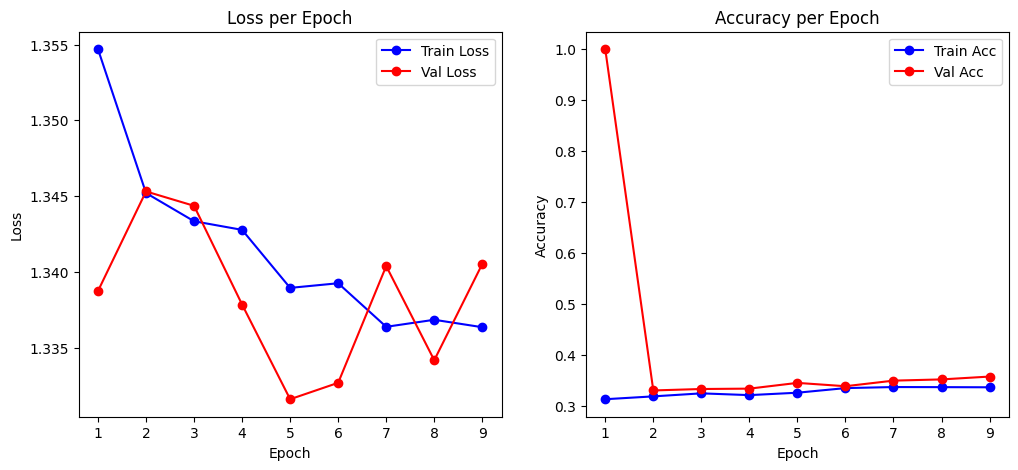

In [17]:
model.plot_metrics()